In [ ]:
#Import library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score


In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Ditemukan GPU di: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("Tidak ada GPU , menggunakan {}.".format(device_name))

Ditemukan GPU di: /device:GPU:0


In [ ]:
#Mounts the google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Declare path
train_dir = "/content/drive/MyDrive/Dataset/Train"
val_dir = "/content/drive/MyDrive/Dataset/Valid"
test_dir = "/content/drive/MyDrive/Dataset/Test"

# **PREPOCESSING**

In [ ]:
#Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    rotation_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)

In [ ]:
#Declare size & Batch
train_batch_size = 30
val_batch_size = 30
test_batch_size = 30
img_height = 150
img_width = 150

In [ ]:
train_ds = train_generator.flow_from_directory(
    directory = train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = train_batch_size,
    shuffle = True,
    seed = 42,
)

val_ds = val_generator.flow_from_directory(
    directory = val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = val_batch_size,
    shuffle = True,
    seed = 42,
)

test_ds = test_generator.flow_from_directory(
    directory = test_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = test_batch_size,
    shuffle = False
)

Found 2684 images belonging to 28 classes.
Found 560 images belonging to 28 classes.
Found 320 images belonging to 28 classes.


In [ ]:
#Display class
class_names = train_ds.class_indices
print(class_names)

{'ayam goreng': 0, 'bakso': 1, 'bakwan': 2, 'bebek betutu': 3, 'burger': 4, 'capcay': 5, 'daging rendang': 6, 'dendeng batokok': 7, 'donat': 8, 'es krim': 9, 'gado gado': 10, 'gudeg': 11, 'gulai ikan': 12, 'gulai tambusu': 13, 'kebab': 14, 'kerak telor': 15, 'mie aceh': 16, 'nasi goreng': 17, 'nasi pecel': 18, 'papeda': 19, 'pempek': 20, 'rawon': 21, 'sate': 22, 'serabi': 23, 'soto lamongan': 24, 'tahu sumedang': 25, 'telur balado': 26, 'tempe goreng': 27}


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(30, 150, 150, 3)
(30, 28)


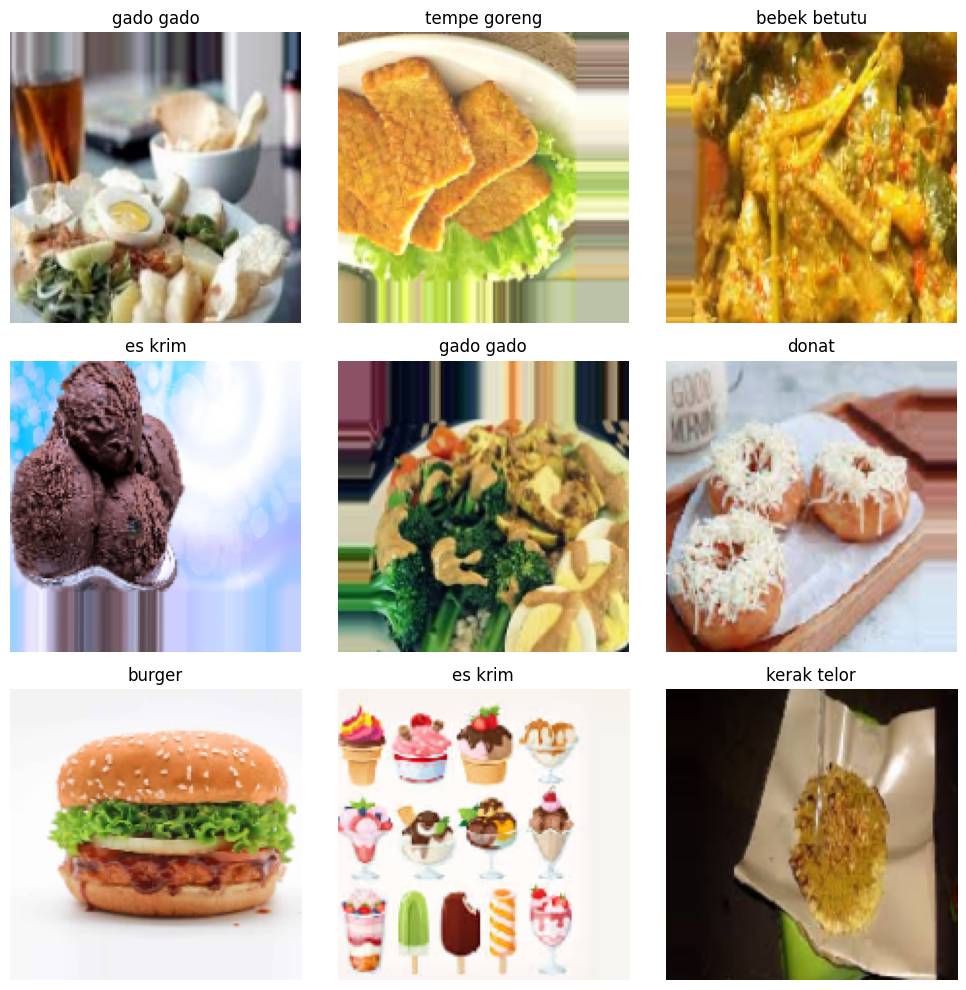

In [ ]:
# Fetch the first batch of images and labels from train_ds
images, labels = next(train_ds)

# Display the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Retrieve the label index from the one-hot encoded format
    label_index = np.argmax(labels[i])

    # Get the class name corresponding to the label index
    for class_name, index in train_ds.class_indices.items():
        if index == label_index:
            plt.title(class_name)
            break

    plt.axis("off")

plt.tight_layout()
plt.show()


# **MAKE THE MODEL**

In [ ]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)



96112376/96112376 [==============================] - 4s 0us/step


In [ ]:
# Adding more layer in top of based model for fine tuning
inputs = pre_trained_model.input

x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Increase dropout

outputs = tf.keras.layers.Dense(28, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
# Set callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
                print("\nReached 85% accuracy in training and validation. Stopping training.")
                self.model.stop_training = True
                print(logs)

callbacks = myCallback()

In [ ]:
# Set training parameters
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['acc'])

In [ ]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 98% accuracy
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 150,
                    callbacks = [callbacks])

Epoch 1/150
90/90 [==============================] - 1973s 21s/step - loss: 3.3189 - acc: 0.1077 - val_loss: 3.3085 - val_acc: 0.1214
Epoch 2/150
90/90 [==============================] - 32s 350ms/step - loss: 3.2525 - acc: 0.1807 - val_loss: 3.2525 - val_acc: 0.1482
Epoch 3/150
90/90 [==============================] - 32s 350ms/step - loss: 3.1494 - acc: 0.2057 - val_loss: 3.1611 - val_acc: 0.2018
Epoch 4/150
90/90 [==============================] - 32s 353ms/step - loss: 3.0017 - acc: 0.2433 - val_loss: 3.0427 - val_acc: 0.1875
Epoch 5/150
90/90 [==============================] - 34s 382ms/step - loss: 2.8099 - acc: 0.3014 - val_loss: 2.8006 - val_acc: 0.3089
Epoch 6/150
90/90 [==============================] - 31s 348ms/step - loss: 2.6202 - acc: 0.3499 - val_loss: 2.7758 - val_acc: 0.3268
Epoch 7/150
90/90 [==============================] - 32s 351ms/step - loss: 2.4776 - acc: 0.3961 - val_loss: 2.4559 - val_acc: 0.4161
Epoch 8/150
90/90 [==============================] - 32s 351ms

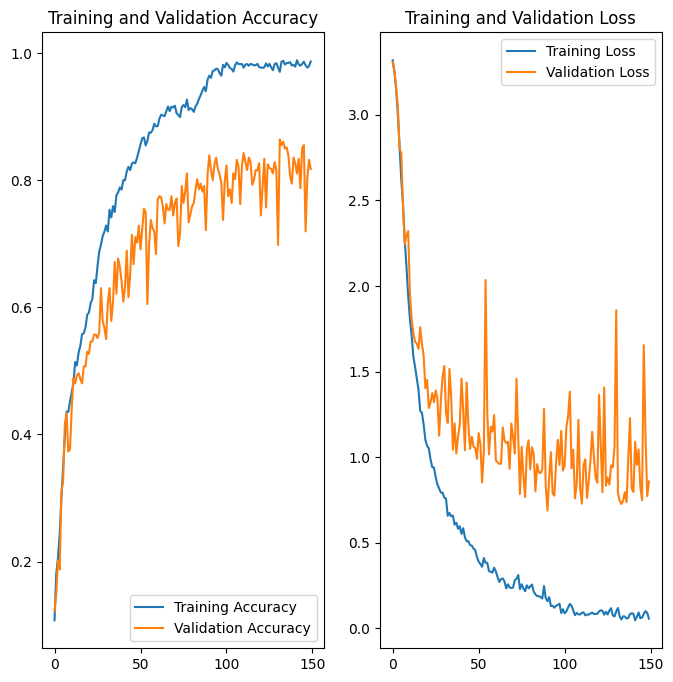

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

11/11 [==============================] - 197s 20s/step


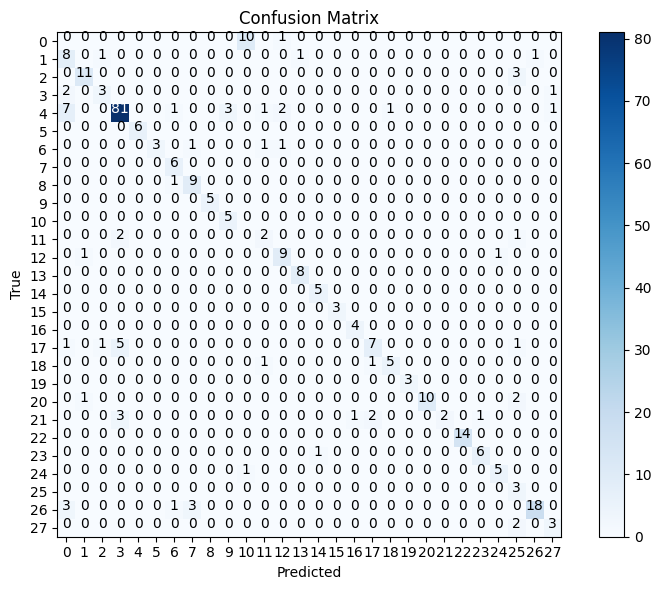


F1 Score: 0.34342705563653453


In [ ]:
# Mendapatkan prediksi dari model pada data uji
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan label sebenarnya dari data uji
y_true = test_ds.classes

# Membuat confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix menggunakan matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = len(np.unique(y_true))
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

plt.xlabel('Predicted')
plt.ylabel('True')

# Menambahkan angka di dalam kotak confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, confusion[i, j],
                 horizontalalignment='center',
                 color='white' if confusion[i, j] > (confusion.max() / 2) else 'black')

plt.tight_layout()
plt.show()

# Menghitung F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nF1 Score:", f1)

11/11 [==============================] - 2s 135ms/step


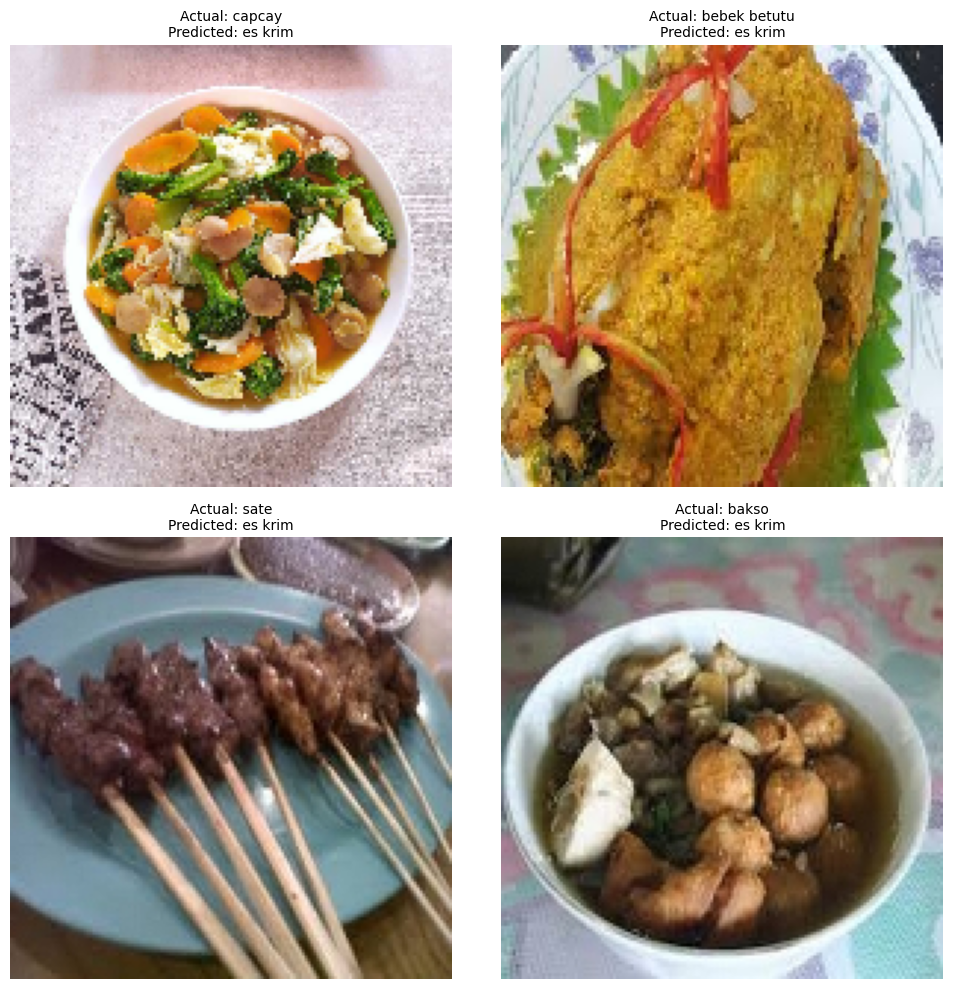

In [ ]:
# Mendapatkan prediksi dari model pada data uji
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan gambar acak dan label dari data uji
num_rows, num_cols = 2, 2
plt.figure(figsize=(10, 10))

for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    # Ambil gambar acak dari test_ds
    rand_index = np.random.randint(len(test_ds))
    image, label = test_ds[rand_index]

    # Tampilkan gambar
    plt.imshow(image[0])
    plt.axis('off')

    # Label actual dan predicted
    true_label = np.argmax(label)  # Ambil label dari tensor dengan argmax
    pred_label = y_pred[rand_index]

    # Konversi label menjadi nama kelas
    true_class = list(test_ds.class_indices.keys())[true_label]
    pred_class = list(test_ds.class_indices.keys())[pred_label]

    # Tambahkan label di atas gambar
    plt.title(f'Actual: {true_class}\nPredicted: {pred_class}', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)